# Cleaning and soft anaylsis on students' behaviour

__Target:__ 4 classes in Vncodelab\
__Data:__ logs of around 200 students in those 4 classes 

__Extract feature:__ 
* Student id
* Participation rate
* Consistancy rate
* consistancy rate in first half semester
* Consistancy rate in second half semester
* Time for reveal (beside the teaching day)
* GPA scores
* Is the subject complusory


__Further development:__ 
* Need to create a time intervals for "teaching", avoiding the change that teachers using slides after "teaching hours" make students losing their "focusing score" and student losing "review time" if they look at the slides later in that day

## 1. Cleaning the dataset

In [1]:
# !pip3 install matplotlib
import codecs
import json
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
subject={
    "Java":["Yorao"],
    "PrmWeb":["X0bMT"],
    "DesWeb":["L71ar","ROmwS","QComg"],
    "Python":["XWTFe"]
}

In [3]:
f= open('data/new_raw_data.json')
data1 = f.read()
classes = json.loads(data1)
f.close()
ava_class=[]
for c in classes:
    ava_class.append(c)

#Currently there is only one teacher in 4 targeted class
teachers=["phamxuanlam@gmail.com"]

### Create a student list

In [4]:
stu = open('data/classes.json')
data=json.load(stu)
stu.close()
data_students=dict()
for cls_name in data:
    if cls_name in ava_class:
        list_stu=data[cls_name]['memberList'].split()
        
        for stu_l in list_stu:
            if stu_l not in teachers:
                data_students[stu_l+'.'+cls_name]=dict()
                data_students[stu_l+'.'+cls_name]['attend']=[]
                data_students[stu_l+'.'+cls_name]['follow_r']=[]
                data_students[stu_l+'.'+cls_name]['follow']=[]
                data_students[stu_l+'.'+cls_name]['review']=0

In [5]:
def to_datetime(s:str) -> datetime:
    datetime_str = s
    datetime_object = datetime.strptime(datetime_str, '%d/%m/%Y, %H:%M:%S')
    return datetime_object
def to_second(a) -> int:
    return 3600*a.hour+60*a.minute+a.second

### Refine the time logs
Tranforms the time logs into consecutive intervals (num=120 for teachers, 90 for students)

[How it done !](Propose_on_changing_time.ipynb)

In [6]:
def generate_time_interval(timeseries,num):
    x=np.array(timeseries,dtype=np.int32)
    rmv=[]
    for i,line in enumerate(x):
        if (line[1]-line[0]<num):
            rmv.append(i)
    x1=np.delete(x,rmv,axis=0)
    rmv2=[]
    for i in range (len(x1)-1):
        if x1[i,2]==x1[i+1,2]:

            x1[i+1,0]=min(x1[i,0],x1[i+1,0])
            x1[i+1,1]=max(x1[i,1],x1[i+1,1])
            rmv2.append(i)
            continue
    x2=np.delete(x1,rmv2,axis=0)
    for i in range (len(x2)-1):
        if x2[i,1]<x2[i+1,0]:
            x2[i,1]=x2[i+1,0]
        elif x2[i,1]>x2[i+1,0]:
            x2[i,1]=x2[i+1,0]
    return x2.tolist()

### Getting the teachers' time

For fast and easy comparision, the list of logs will have another copy that mostly in dictionary

In [7]:
#require rooms_id
def get_teacher_time_intervals(classs,rooms_id,teacher):
    #store moves as a 2d numpy->list 
    teacher_step_dictionary= dict()
    teacher_email= teacher
    for room in rooms_id:
        teacher_step_dictionary[room]= dict()
        for i in range(len(classs[room]["users"])):
            if classs[room]["users"][i]['email'] in teacher_email:
                
                try:
                    teacher_step_dictionary[room]['teacher']=classs[room]["users"][i]['email']
                    temp_teach_day=dict() #to_datetime(classs[room]["users"][i]['logs'][0]['time']).date()
                    for day in classs[room]["users"][i]["logs"]:
                        if to_datetime(day['time']).date().strftime("%d/%m/%Y") not in temp_teach_day:
                            temp_teach_day[to_datetime(day['time']).date().strftime("%d/%m/%Y")]=0
                        temp_teach_day[to_datetime(day['time']).date().strftime("%d/%m/%Y")]+=1
                    mx_t=0
                    t=to_datetime(classs[room]["users"][i]['logs'][0]['time']).strftime("%d/%m/%Y")
                    for date in temp_teach_day:
                        if temp_teach_day[date]>mx_t:
                            mx_t=temp_teach_day[date]
                            t=date
                    teach_day=datetime.strptime(t,"%d/%m/%Y").date()
                    teacher_step_dictionary[room]['date']=teach_day
                    teacher_step_dictionary[room]['temp_steps'] =[]
                    for k in range(len(classs[room]["users"][i]["logs"])):
                        if to_datetime(classs[room]["users"][i]["logs"][k]['time']).date()==teach_day:
                            teacher_step_dictionary[room]['temp_steps'].append([to_second(to_datetime(classs[room]["users"][i]["logs"][k]['time'])),\
                                                        to_second(to_datetime(classs[room]["users"][i]["logs"][k]['time']))+classs[room]["users"][i]["logs"][k]['duration'],\
                                                        classs[room]["users"][i]["logs"][k]['enter']])
                    break
                except:
                    teacher_step_dictionary[room]['temp_steps']=[]
                    teacher_step_dictionary[room]['date']=datetime.strptime("01/01/2024",'%d/%m/%Y')
                
    for room in teacher_step_dictionary:
        if len(teacher_step_dictionary[room]['temp_steps'])>0:
            teacher_step_dictionary[room]['temp_steps'].sort()
            teacher_step_dictionary[room]['steps']=generate_time_interval(teacher_step_dictionary[room]['temp_steps'],120)
            teacher_step_dictionary[room]['temp_steps'].clear()
        else:
            teacher_step_dictionary[room]['steps']=[[0,1,0]]
    return teacher_step_dictionary

In [ ]:
def teacher_time_to_dict(teacher_moves):
    #stored as a key-value pair for compare
    moves=dict()
    for room in teacher_moves:
        moves[room]=dict()
        moves[room]['date']=teacher_moves[room]['date']
        moves[room]['steps']=dict()
        for move in teacher_moves[room]['steps']:
            if str(move[2]) not in moves[room]['steps']:
                moves[room]['steps'][str(move[2])]=[]
            moves[room]['steps'][str(move[2])].append([move[0],move[1]])
    return moves  

### Collecting the students' time logs and present in different rooms

In [8]:
def get_student_time_intervals_per_class(classs,class_room,date,teacher):
    #Get the time intervals of all student
    #Return both in_class and review logs
    students_step_dictionary=dict()
    # students_review=dict()
    l=-1
    for stu_l in data_students:
        if '.'+classs in stu_l:
            if l !=-1:
                l=len(data_students[stu_l]['attend'])
            data_students[stu_l]['attend'].append(0)
    
    for user in class_room["users"]:
        if user["email"] != teacher and user["email"]+'.'+classs in data_students:
            # review_time=0
            temp_time=[]
            for time in user["logs"]:
                if to_datetime(time['time']).date()==date:
                    data_students[user["email"]+'.'+classs]['attend'][l]=1
                    temp_time.append([to_second(to_datetime( time['time'] )),to_second(to_datetime( time['time'] ))+time['duration'],time['enter']])
                else:
                    # review_time+=time['duration']
                    data_students[user["email"]+'.'+classs]['review']+=time['duration']
            temp_time.sort()
            students_step_dictionary[user["email"]+'.'+classs]=generate_time_interval(temp_time,90)
            # students_review[user["email"]+'.'+classs]=review_time
            temp_time.clear()
            
    return  students_step_dictionary

### Fitting the students' interval with the teachers' ones

The students' interval are still stored for later analysis (if needed)

In [ ]:
def check_interval(st,t):
    
    # Get the right join of 2 intervals
    
    if st[0]>=t[0]and st[1]<=t[1]:
        return [st[0],st[1]]
    if st[0]<=t[0] and st[1]<=t[1]:
        if st[1]>=t[0]:
            return [t[0],st[1]]
        return [0,0]
    if st[0]>=t[0] and st[1]>=t[1]:
        if t[1]>=st[0]:
            return [st[0],t[1]]
        return [0,0]
    if st[0]<=t[0] and st[1]>=t[1]:
        return [t[0],t[1]]
    return 0,0

In [9]:
def follow_up_in_general(teacher_step,student_steps):
    #check the inner join of 2 space: teacher and student at a certain slide
    student_shaded_area=dict()
    for student in student_steps:
        shaded_area=[]
        for move in student_steps[student]:
            # print(move)
            if str(move[2]) not in teacher_step:
                continue
            else :
                for t_mv in teacher_step[str(move[2])]:
                    if check_interval([move[0],move[1]],t_mv) !=[0,0]:
                        shaded_area.append(check_interval([move[0],move[1]],t_mv)+[move[2]])
        shaded_area.sort()
        student_shaded_area[student]=shaded_area
    return student_shaded_area

### Follow up with restriction
This function will count the amount of time that student change the slides after the direction of teacher. The delay is set to lower than lim (we use 60s in this case)
### Follow up without restriction
This function will count the time that student follow the teacher (inner join of 2 intervals)

In [10]:
#teacher_moves_dict
def follow_up_with_restrict(teacher_step,student_step,lim):
    # force user to follow teacher only after a certain amount of time (declared by lim)
    # re=dict()
    for student in student_step:
        start=dict()
        corr=0
        lens=0
        for mv in student_step[student]:
            if str(mv[2]) not in start:
                start[str(mv[2])]=[]
            start[str(mv[2])].append(mv[0])
        for slide in teacher_step:
            lens+=len(teacher_step[slide])
            if slide in start:
                for mv in teacher_step[slide]:
                
                    for st_mv in start[slide]:
                        if st_mv in range(mv[0],mv[0]+lim+1):
                            corr += 1
                            break
        # re[student]=max(0,min(corr/lens,1))
        data_students[student]['follow_r'].append(max(0,min(corr/lens,1)))
        
    # return re

In [11]:
#teacher_moves
def follow_up_without_restrict(teacher_step,student_step):
    # only calcuate total time of student/teacher (tracked)
    # re=dict()
    teacher_time=0
    for mv in teacher_step:
        teacher_time+=(mv[1]-mv[0])
    for student in student_step:
        student_time=0
        for mv in student_step[student]:
            student_time+=(mv[1]-mv[0])
        # re[student]=max(0,min(student_time/teacher_time,1))
        data_students[student]['follow'].append(max(0,min(student_time/teacher_time,1)))
    # return re

### For further analysis, I also save the timestamps in json format

In [34]:
students_timestamps=dict()
teachers_timestamps=dict()
for cls_name in ava_class:
    students_timestamp[cls_name]=dict()
    # teachers_timestamp[cls_name]=dict()

### Example of time intervals in a lecture

We will take a random class as an example of how the algorithms can match the students' time with teachers' time

Let's choose room '8JSMUQ' in class 'Yorao' for a clear example


In [12]:
Yorao=classes["Yorao"]
rooms_id = [room for room in classes["Yorao"]]
teacher_moves=get_teacher_time_intervals(Yorao,rooms_id,teachers)
students_moves=get_student_time_intervals_per_class("Yorao",Yorao['8JSMUQ'],teacher_moves['8JSMUQ']['date'],teacher_moves['8JSMUQ']['teacher'])
teacher_moves_dict=teacher_time_to_dict(teacher_moves)
x1=follow_up_in_general(teacher_moves_dict['8JSMUQ']['steps'],students_moves)


#### Teacher's timestamp

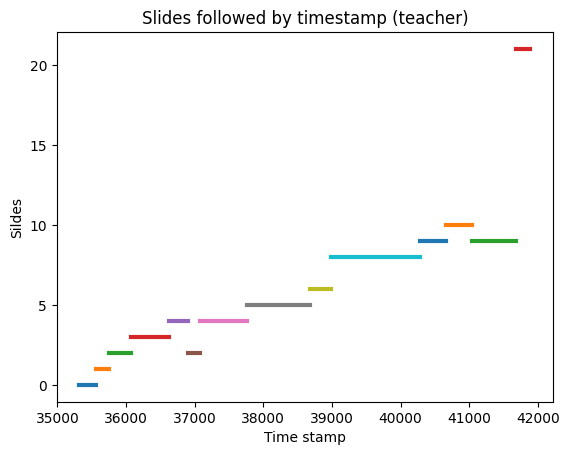

In [26]:
x2=np.array(teacher_moves['8JSMUQ']['steps'])
plt.plot([x2[:,0],x2[:,1]],[x2[:,2],x2[:,2]],linewidth=3)
plt.ylabel('Sildes') 
plt.xlabel('Time stamp (s)')
plt.title("Slides followed by timestamp (teacher)")
plt.show()

#### Students' timestamp 

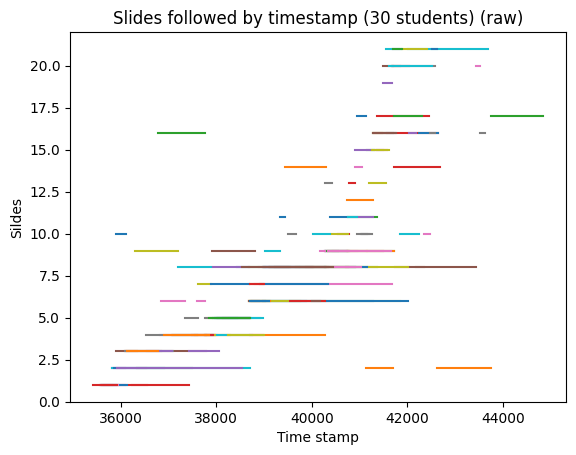

In [27]:
stop=30
a=stop
s="s" if a>1 else ""
for stu in students_moves: #any<40
    x2=np.array(students_moves[stu])
    if x2.shape[0]>0:
        plt.plot([x2[:,0],x2[:,1]],[x2[:,2],x2[:,2]])

    stop-=1
    if stop==0:
        break
plt.ylabel('Sildes') 
plt.xlabel('Time stamp (s)')
plt.title(f"Slides followed by timestamp ({a} student{s}) (raw)")
plt.show()

#### Students' timestamp after matching with teacher's timestamp

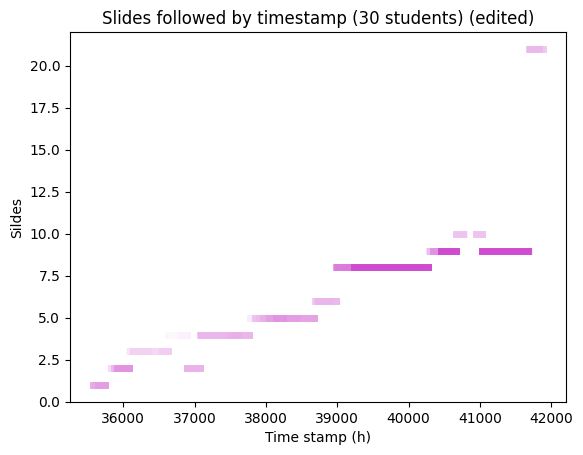

In [33]:
stop=30
a=stop
s="s" if a>1 else ""
for stu in x1: #any<40
    x2=np.array(x1[stu])
    if x2.shape[0]>0:
        plt.plot([x2[:,0],x2[:,1]],[x2[:,2],x2[:,2]],color='#CF4CD0',alpha=1/stop,linewidth=5)

    stop-=1
    if stop==0:
        break
plt.ylabel('Sildes') 
plt.xlabel('Time stamp (h)')
plt.title(f"Slides followed by timestamp ({a} student{s}) (edited)")
plt.show()

Each student have different time logs, and we have to collect only the time that student spend on the class \
We started to see the similar pattern of students' move to teacher' move after changing the time intervals of students\
In this class, we can see that students paying attention mostly in the later half of the lecture

In [ ]:
def analysis_a_room(classs,room_id,teacher_moves,teacher_moves_dict):
    students_moves=get_student_time_intervals_per_class(classs,classes[classs][room_id],teacher_moves[room_id]['date'],teacher_moves[room_id]['teacher'])
    x1=follow_up_in_general(teacher_moves_dict[room_id]['steps'],students_moves)
    follow_up_with_restrict(teacher_moves_dict[room_id]['steps'],x1,60)
    follow_up_without_restrict(teacher_moves[room_id]['steps'],x1)
    students_timestamps[classs][room_id]=x1

In [ ]:
# save all student in a dict ->numpy ->pandas
def analysis_a_class(cls_name):
    rooms_id=[]
    for room in classes[cls_name]:
        rooms_id.append(room)
    teacher_moves=get_teacher_time_intervals(classes[cls_name],rooms_id,teachers)
    teacher_moves_dict=teacher_time_to_dict(teacher_moves)
    teachers_timestamps[classs]=teacher_moves
    for room in rooms_id:
        
        if len(teacher_moves[room]['steps']) >1:
            analysis_a_room(cls_name,room,teacher_moves,teacher_moves_dict)

### Frequency
This function will return how consistancy the student is [participant rate, consistancy rate, consistancy in first half semester, consistancy in second half semester] \
consistancy: evaluate the consistance of a student(1 is either allway study or never study, 0 is always skip the class after)

In [ ]:
def frequency(array):
    a=0
    shift=0
    l_shift=0
    r_shift=0
    mid=len(array)//2
    for i in range(len(array)-1):
        if array[i]==1:
            a+=1
            if array[i+1]==0:
                shift+=1
                if i<=mid:
                    l_shift+=1
                else:
                    r_shift+=1
    if array[-1]==1:
        a+=1
        if array[-2]==0:
            r_shift+=1
    return [a/len(array),(1-shift*2/len(array)),max(0,(1-l_shift*2/mid)),max(0,(1-r_shift*2/(len(array)-mid)))]
        

In [ ]:
#redefine data_students
data_students=dict()
for cls_name in data:
    if cls_name in ava_class:
        list_stu=data[cls_name]['memberList'].split()
        for stu_l in list_stu:
            if stu_l not in teachers:
                data_students[stu_l+'.'+cls_name]=dict()
                data_students[stu_l+'.'+cls_name]['attend']=[]
                data_students[stu_l+'.'+cls_name]['follow_r']=[]
                data_students[stu_l+'.'+cls_name]['follow']=[]
                data_students[stu_l+'.'+cls_name]['review']=0

In [ ]:
for cls_name in classes:
    analysis_a_class(cls_name)

In [ ]:
with open('data/teachers_timestamps.json','w') as ts:
    ts.dump(teachers_timestamps,ts)
with open('data/students_timestamps.json','w') as ts:
    ts.dump(students_timestamps,ts)

In [ ]:
def sum_up(data_students):
    for stu in data_students:
        # print(stu,len(data_students[stu]['attend']))
        data_students[stu]['f_ad']=frequency(data_students[stu]['attend'])
        data_students[stu]['a_f']=(sum(data_students[stu]['follow']))/(len(data_students[stu]['follow'])+1e-7)
        data_students[stu]['a_f_r']=sum(data_students[stu]['follow_r'])/(len(data_students[stu]['follow_r'])+1e-7)
sum_up(data_students)


In [ ]:
refined=[]
for stu in data_students:
    refined.append([stu,\
                    data_students[stu]['f_ad'][0],\
                    data_students[stu]['f_ad'][1],\
                    data_students[stu]['f_ad'][2],\
                    data_students[stu]['f_ad'][3],\
                    data_students[stu]['a_f'],\
                    data_students[stu]['a_f_r'],\
                    data_students[stu]['review']])


In [ ]:
def to_id(s:str) ->str:
    regex = r"^[a-zA-Z0-9_.+-]+@"    
    email_address = s
    first_part = re.match(regex, email_address).group()
    student_id= first_part[:-1]
    return student_id

col=['s-email','% participate','consistency','c_in_f_half','c_in_s_half','following','immediate_f','review']
df=pd.DataFrame(refined,columns=col)
df["Student id"]=[int(to_id(x)) if to_id(x).isdigit() else 1000 for x in df['s-email'] ]
df["Class"]=[x[-5:] for x in df['s-email']]
rvs=dict()
for sub in subject:
    for clss in subject[sub]:
        rvs[clss]=sub 
df["Subject"]=[rvs[x] for x in df["Class"]]
df.head()

,s-email,% participate,consistency,c_in_f_half,c_in_s_half,following,immediate_f,review,Student id,Class,Subject
0,11218439@st.neu.edu.vn.L71ar,1.000000,1.000000,1.000000,1.0,0.519011,0.482784,53,11218439,L71ar,DesWeb
1,11200006@st.neu.edu.vn.L71ar,1.000000,1.000000,1.000000,1.0,0.282074,0.209524,4823,11200006,L71ar,DesWeb
2,11207605@st.neu.edu.vn.L71ar,0.714286,0.428571,0.333333,0.0,0.165560,0.066667,16,11207605,L71ar,DesWeb
3,11218442@st.neu.edu.vn.L71ar,0.857143,0.714286,0.333333,1.0,0.064218,0.058608,0,11218442,L71ar,DesWeb
4,11211178@st.neu.edu.vn.L71ar,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0,11211178,L71ar,DesWeb
...,...,...,...,...,...,...,...,...,...,...,...
207,11218435@st.neu.edu.vn.Yorao,0.800000,0.800000,1.000000,0.2,0.473855,0.497031,8771,11218435,Yorao,Java
208,11218437@st.neu.edu.vn.Yorao,0.600000,0.400000,0.200000,0.6,0.145689,0.166094,24715,11218437,Yorao,Java
209,11218438@st.neu.edu.vn.Yorao,0.600000,0.600000,0.600000,0.6,0.079222,0.025893,6996,11218438,Yorao,Java
210,nerdyjeb@gmail.com.Yorao,0.300000,0.400000,0.200000,0.6,0.097483,0.078125,4492,1000,Yorao,Java


### Some plots that might be cool

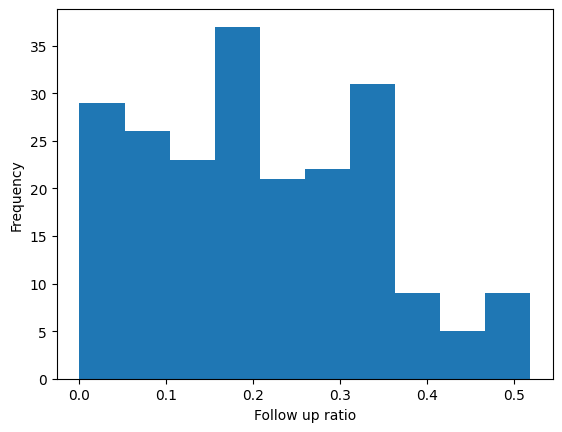

In [ ]:
plt.hist(df['following'])
plt.xlabel("Follow up ratio")
plt.ylabel("Frequency")
plt.show()

It can be seen from the chart that most students have the total amount of time following the teachers are less than 50%.\
It can somehow be explained that they might choose to follow the teachers' slideshow in the class rather than their own slides in their laptops. That reason can also be explained the low ratio of "immediate following up".

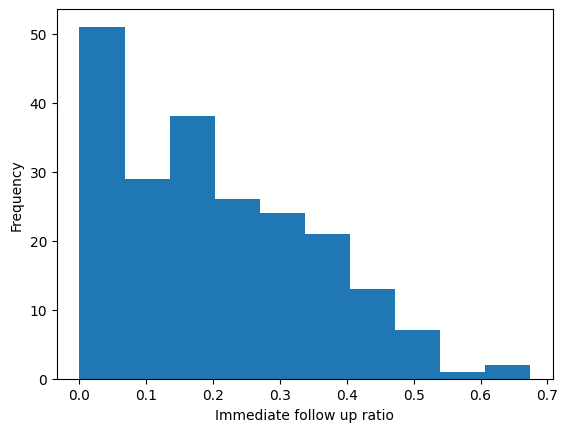

In [ ]:
plt.hist(df['immediate_f'])
plt.xlabel("Immediate follow up ratio")
plt.ylabel("Frequency")
plt.show()

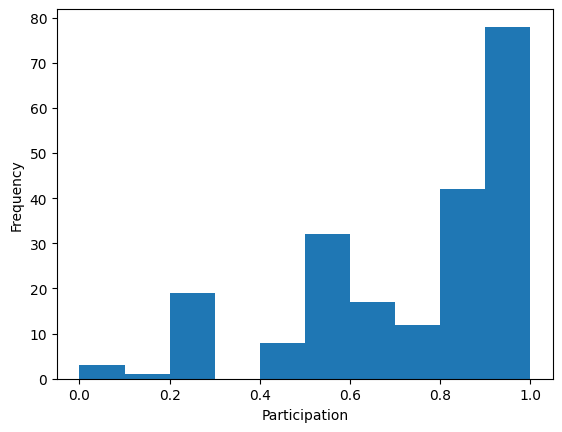

In [ ]:
plt.hist(df['% participate'])
plt.xlabel("Participation")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Specify the path to the CSV file
# Old Average attentions are wrong
# csv_fileyorao = "Java_63KHMT.csv"
# csv_filexbomt = "CNWeb.csv"
# csv_fileromws = "TKWeb.csv"
# csv_filel71ar = "TKWeb1.csv"
# # Read the CSV file into a Pandas DataFrame
# df_cnw = pd.read_csv(csv_filexbomt, sep=",",encoding="utf-8")[["Student id","Attendance","Average","Compulsory"]]
# df_java = pd.read_csv(csv_fileyorao, sep=",",encoding="utf-8")[["Student id","Attendance","Average","Compulsory"]]
# df_tkw1 = pd.read_csv(csv_fileromws, sep=",",encoding="utf-8")[["Student id","Attendance","Average","Compulsory"]]
# df_tkw2 = pd.read_csv(csv_filel71ar, sep=",",encoding="utf-8")[["Student id","Attendance","Average","Compulsory"]]
# # Print the DataFrame
# df_java["Subject"]="Java"
# df_tkw2["Subject"]="DesWeb"
# df_cnw["Subject"]="PrmWeb"
# df_tkw1["Subject"]="DesWeb"
# frames=[df_java,df_tkw2,df_cnw,df_tkw1]
# all_data_score = pd.concat(frames)
# # all_data_score.isna().sum()
# all_data_score.to_csv("all_students_grade.csv")

## 2 Evaluating the dataset

Get some basic information of the dataset

In [ ]:
all_data_score = pd.read_csv("data/all_students_grade.csv")
result = pd.merge(df, all_data_score,how="left", on=["Student id", "Subject"]).dropna()
result.groupby(["Class"])[["% participate","consistency","following","immediate_f","review","Compulsory","Attendance","Average"]].mean()

,% participate,consistency,following,immediate_f,review,Compulsory,Attendance,Average
Class,,,,,,,,
L71ar,0.771429,0.702857,0.257541,0.240473,2394.200000,0.500000,7.820000,7.621000
ROmwS,0.736207,0.731034,0.178275,0.168475,6427.862069,0.974138,8.689655,8.045690
X0bMT,0.870130,0.844156,0.242525,0.282410,2273.575758,0.484848,9.090909,7.695455
Yorao,0.736207,0.651724,0.196729,0.182842,26324.086207,0.965517,8.586207,7.735345


It seem that the class "L71ar" have a sigificant lower Attendance and Average score. For a fair comparison, each student in class "L71ar" will earn min(current point+1,10) which incearse the mean Attendance score to 0.5 ->1 point and Average to around 0.1 point

In [ ]:
result["Average"]=np.where((result["Attendance"]<10) & (result["Class"]=="L71ar"),result["Average"]+0.1,result["Average"])
result["Attendance"]=np.where((result["Attendance"]<10) & (result["Class"]=="L71ar"),result["Attendance"]+1,result["Attendance"])
result.groupby(["Class"])[["% participate","consistency","following","immediate_f","review","Compulsory","Attendance","Average"]].mean()

,% participate,consistency,following,immediate_f,review,Compulsory,Attendance,Average
Class,,,,,,,,
L71ar,0.771429,0.702857,0.257541,0.240473,2394.200000,0.500000,8.660000,7.705000
ROmwS,0.736207,0.731034,0.178275,0.168475,6427.862069,0.974138,8.689655,8.045690
X0bMT,0.870130,0.844156,0.242525,0.282410,2273.575758,0.484848,9.090909,7.695455
Yorao,0.736207,0.651724,0.196729,0.182842,26324.086207,0.965517,8.586207,7.735345


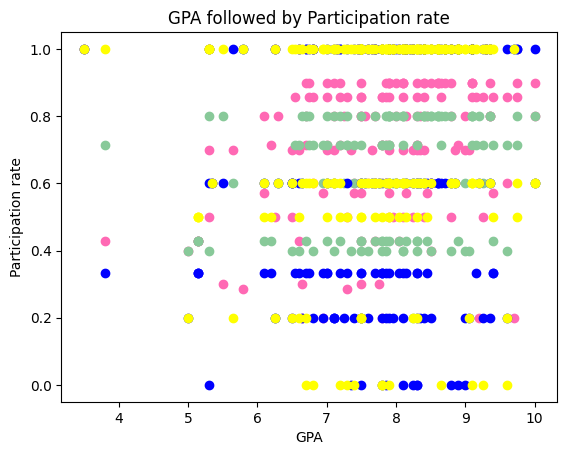

Pink  : GPA based on % participation
Green : GPA based on the consistency of student
Blue  : GPA based on the consistency of student in the first half of the semester
Yellow: GPA based on the consistency of student in the second half of the semester


In [ ]:
plt.scatter(result["Average"],result["% participate"],color = 'hotpink')
plt.scatter(result["Average"],result["consistency"],color = '#88c999')
plt.scatter(result["Average"],result["c_in_f_half"],color = 'blue')
plt.scatter(result["Average"],result["c_in_s_half"],color = 'yellow')
# plt.scatter(result["Average"],result["% p in half_s"])
plt.ylabel('Participation rate') 
plt.xlabel('GPA')
plt.title("GPA followed by Participation rate")
plt.show()
print("Pink  : GPA based on % participation")
print("Green : GPA based on the consistency of student")
print("Blue  : GPA based on the consistency of student in the first half of the semester")
print("Yellow: GPA based on the consistency of student in the second half of the semester")

#look gross :<<

The group of student with high consistences and participant rate tent to get better gpa.

Student lack less focus in the second half of the semester in comparision with the first half.

### More analysis will come up later

## Modeling
We will not going too deep on building the model. Still having a great model that can be applied into the website could be a great deal for either teachers and students

### 1. Given the students behaviours, predict the students Attendance Score
1. Using softmax (accuracy =67.5%)
2. Using linear regression (MSE = 0.61)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

For Logistic Regression, it is better to reduce the requirement for the output to only predict where the student is good (=10), above average (>=8), average (>=6) and below average(>=4) \
Disclaim: It is unethincal to grade the student's attendance score below 4

### Softmax Regression

In [ ]:
X=result[["% participate","consistency","following","immediate_f","review","Compulsory"]]
y=result["Attendance"].astype("int32")
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
#try LR better option
y_train2=(y_train//2)*2
y_test2=(y_test//2)*2
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=4)

In [ ]:
param_test={
    'tol':[0.0001,0.00001,0.0000001],
    'C':[2,1.5,1,0.5,0.1,0.01,0.001,0.0001],
    'solver':['liblinear','lbfgs'],
    
}
regr =GridSearchCV(estimator = LogisticRegression(class_weight="balanced",random_state=10),
                   param_grid=param_test
                   )
regr.fit(X_train,y_train2)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=10),
             param_grid={'C': [2, 1.5, 1, 0.5, 0.1, 0.01, 0.001, 0.0001],
                         'solver': ['liblinear', 'lbfgs'],
                         'tol': [0.0001, 1e-05, 1e-07]})

In [ ]:

yhat=regr.predict(X_test)
print(np.mean((yhat-y_test2)**2))
# print(np.mean((regr.predict(X_train)-y_train)**2))
from sklearn import metrics
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, regr.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test2, yhat))

1.3
Test set Accuracy:  0.675


Confusion matrix, without normalization
[[19  3  0  0]
 [ 3  8  3  0]
 [ 0  2  0  1]
 [ 0  0  1  0]]


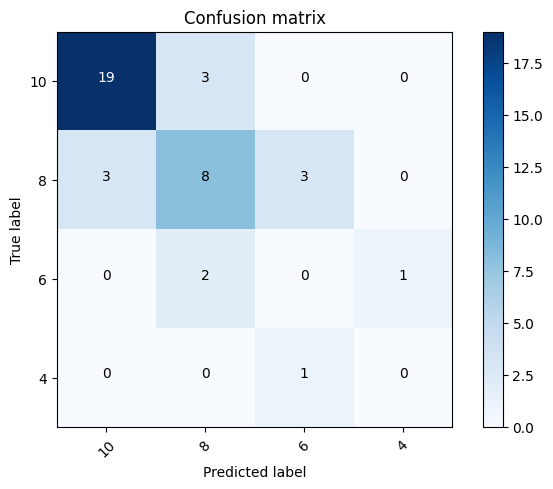

In [ ]:
cnf_matrix = confusion_matrix(y_test2, yhat, labels=[10,8,6,4])
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[x for x in range(10,3,-2)],normalize= False,  title='Confusion matrix')

### Linear Regression

In [ ]:
regr = LinearRegression()
regr.fit(X_train,y_train)

LinearRegression()

In [ ]:
yhat=regr.predict(X_test)
print('MSE')
print(np.mean((yhat-y_test)**2))
#Can not find anyone better than u huhuhu

MSE
0.6192324667762458


In [ ]:
# import xgboost as xgb
# XGBoost not perform well

In [ ]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# param_test = {
#     'reg_alpha':[1e-5, 1e-2, 0.1, 100],
#     'learning_rate':[0.01,0.1,0.2],
#     'subsample':[i/10.0 for i in range(6,10)],

#     'min_child_weight':[6,8,10,12]
# }
# gsearch = GridSearchCV(estimator =xgb.XGBClassifier(

#                         missing=1,
                        
#                         max_depth=20,\
#                         eta=0.1,\
#                         min_child_weight=2,
                        
#                         gamma=0.1,
#                         seed=35,
#                         scoring='roc_auc'
#                         ),param_grid=param_test,cv=2,verbose=10)
# gsearch.fit(X_train,y_train)

In [ ]:
# print(np.mean((gsearch.predict(X_test)-y_test)**2))

## 2 Predict GPA given Attendance

Either way the prediction is not as accurate as the previous tasks

In [ ]:
X=result[["% participate","consistency","following","immediate_f","review","Compulsory","Attendance"]]
y=result["Average"].astype("int32")
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [ ]:
regr = LogisticRegression(tol=0.00001,C=0.5,class_weight="balanced",solver='liblinear',random_state=10)
regr.fit(X_train,y_train)

LogisticRegression(C=0.5, class_weight='balanced', random_state=10,
                   solver='liblinear', tol=1e-05)

In [ ]:
yhat=regr.predict(X_test)
print(np.mean((yhat-y_test)**2))
# print(np.mean((regr.predict(X_train)-y_train)**2))
from sklearn import metrics
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, regr.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

2.425
Test set Accuracy:  0.35


In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[10,9,8,7,6,5])
cnf_matrix
# weird shape

array([[1, 0, 0, 0, 0, 0],
       [4, 0, 5, 1, 0, 0],
       [1, 0, 9, 1, 0, 0],
       [3, 0, 5, 4, 0, 1],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 1, 1, 0, 0]], dtype=int64)

In [ ]:
regr = LinearRegression()
regr.fit(X_train,y_train)
yhat=regr.predict(X_test)
print('MSE')
print(np.mean((yhat-y_test)**2))

MSE
1.4333038563782279
